In [1]:
from __future__ import division
from __future__ import print_function

import time
import argparse
import numpy as np

import torch
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn
from torch.nn.parameter import Parameter
from torch.nn.modules.module import Module

from utils import normalize, sparse_mx_to_torch_sparse_tensor, accuracy
from scipy.sparse import csr_matrix, coo_matrix, diags,eye



In [2]:
class graph_convolution_layer(Module):

    def __init__(self, in_features, out_features):
        super(graph_convolution_layer, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = Parameter(torch.FloatTensor(in_features, out_features))
        self.bias = Parameter(torch.FloatTensor(out_features))
        self.weight.data.uniform_(-0.1, 0.1)
        self.bias.data.uniform_(-0.1, 0.1)


    def forward(self, input, adj):
        support = torch.mm(input, self.weight)
        output = torch.spmm(adj, support)
        return output + self.bias

class GCN(nn.Module):
    def __init__(self, nfeat, nhid, nclass, dropout):
        super(GCN, self).__init__()

        self.gc1 = graph_convolution_layer(nfeat, nhid)
        self.gc2 = graph_convolution_layer(nhid, nclass)
        self.dropout = dropout

    def forward(self, x, adj):
        x = F.relu(self.gc1(x, adj))
        embedding = x
        x = F.dropout(x, self.dropout, training=self.training)
        
        x = self.gc2(x, adj)
        return embedding, F.log_softmax(x, dim=1)


In [3]:

seed = 42
epochs = 200
lr = 0.01
weight_decay = 5e-4
hidden = 16
dropout = 0.5

np.random.seed(seed)
torch.manual_seed(seed)




In [4]:
# Read and process data


nodes = np.genfromtxt("{}{}.content".format('cora/', 'cora'), dtype=np.dtype(str))
edges = np.genfromtxt("{}{}.cites".format('cora/', 'cora'), dtype=np.int32)


features = np.array(nodes[:, 1:-1], dtype = np.float32)
features = normalize(csr_matrix(features, dtype=np.float32))

labels = nodes[:, -1]
classes = np.unique(labels)
one_hot_classes = dict(zip(classes, np.squeeze(np.eye(len(classes))[list(range(len(classes)))])))
one_hot_labels = np.array([one_hot_classes[i] for i in labels])

idx = np.array(nodes[:, 0], dtype=np.int32)
idx_map = {j: i for i, j in enumerate(idx)}

edges = np.array(list(map(idx_map.get, edges.flatten())), dtype=np.int32).reshape(edges.shape)
adj = coo_matrix((np.ones(2*edges.shape[0]), (np.concatenate((edges[:, 0], edges[:, 1]), axis=0), np.concatenate((edges[:, 1], edges[:, 0]), axis=0))), shape=(labels.shape[0], labels.shape[0]), dtype=np.float32)


adj = adj + eye(adj.shape[0])
adj = coo_matrix(adj)
rowsum = np.array(adj.sum(1))
d_inv_sqrt = np.power(rowsum, -0.5).flatten()
d_inv_sqrt[np.isinf(d_inv_sqrt)] = 0.
d_mat_inv_sqrt = diags(d_inv_sqrt)
adj = adj.dot(d_mat_inv_sqrt).transpose().dot(d_mat_inv_sqrt).tocoo()

idx_train = range(27)
idx_val = range(27, 2500)
idx_test = range(27, 2500)

features = torch.FloatTensor(np.array(features.todense()))
labels = torch.LongTensor(np.where(one_hot_labels)[1])
adj = sparse_mx_to_torch_sparse_tensor(adj)

idx_train = torch.LongTensor(idx_train)
idx_val = torch.LongTensor(idx_val)
idx_test = torch.LongTensor(idx_test)




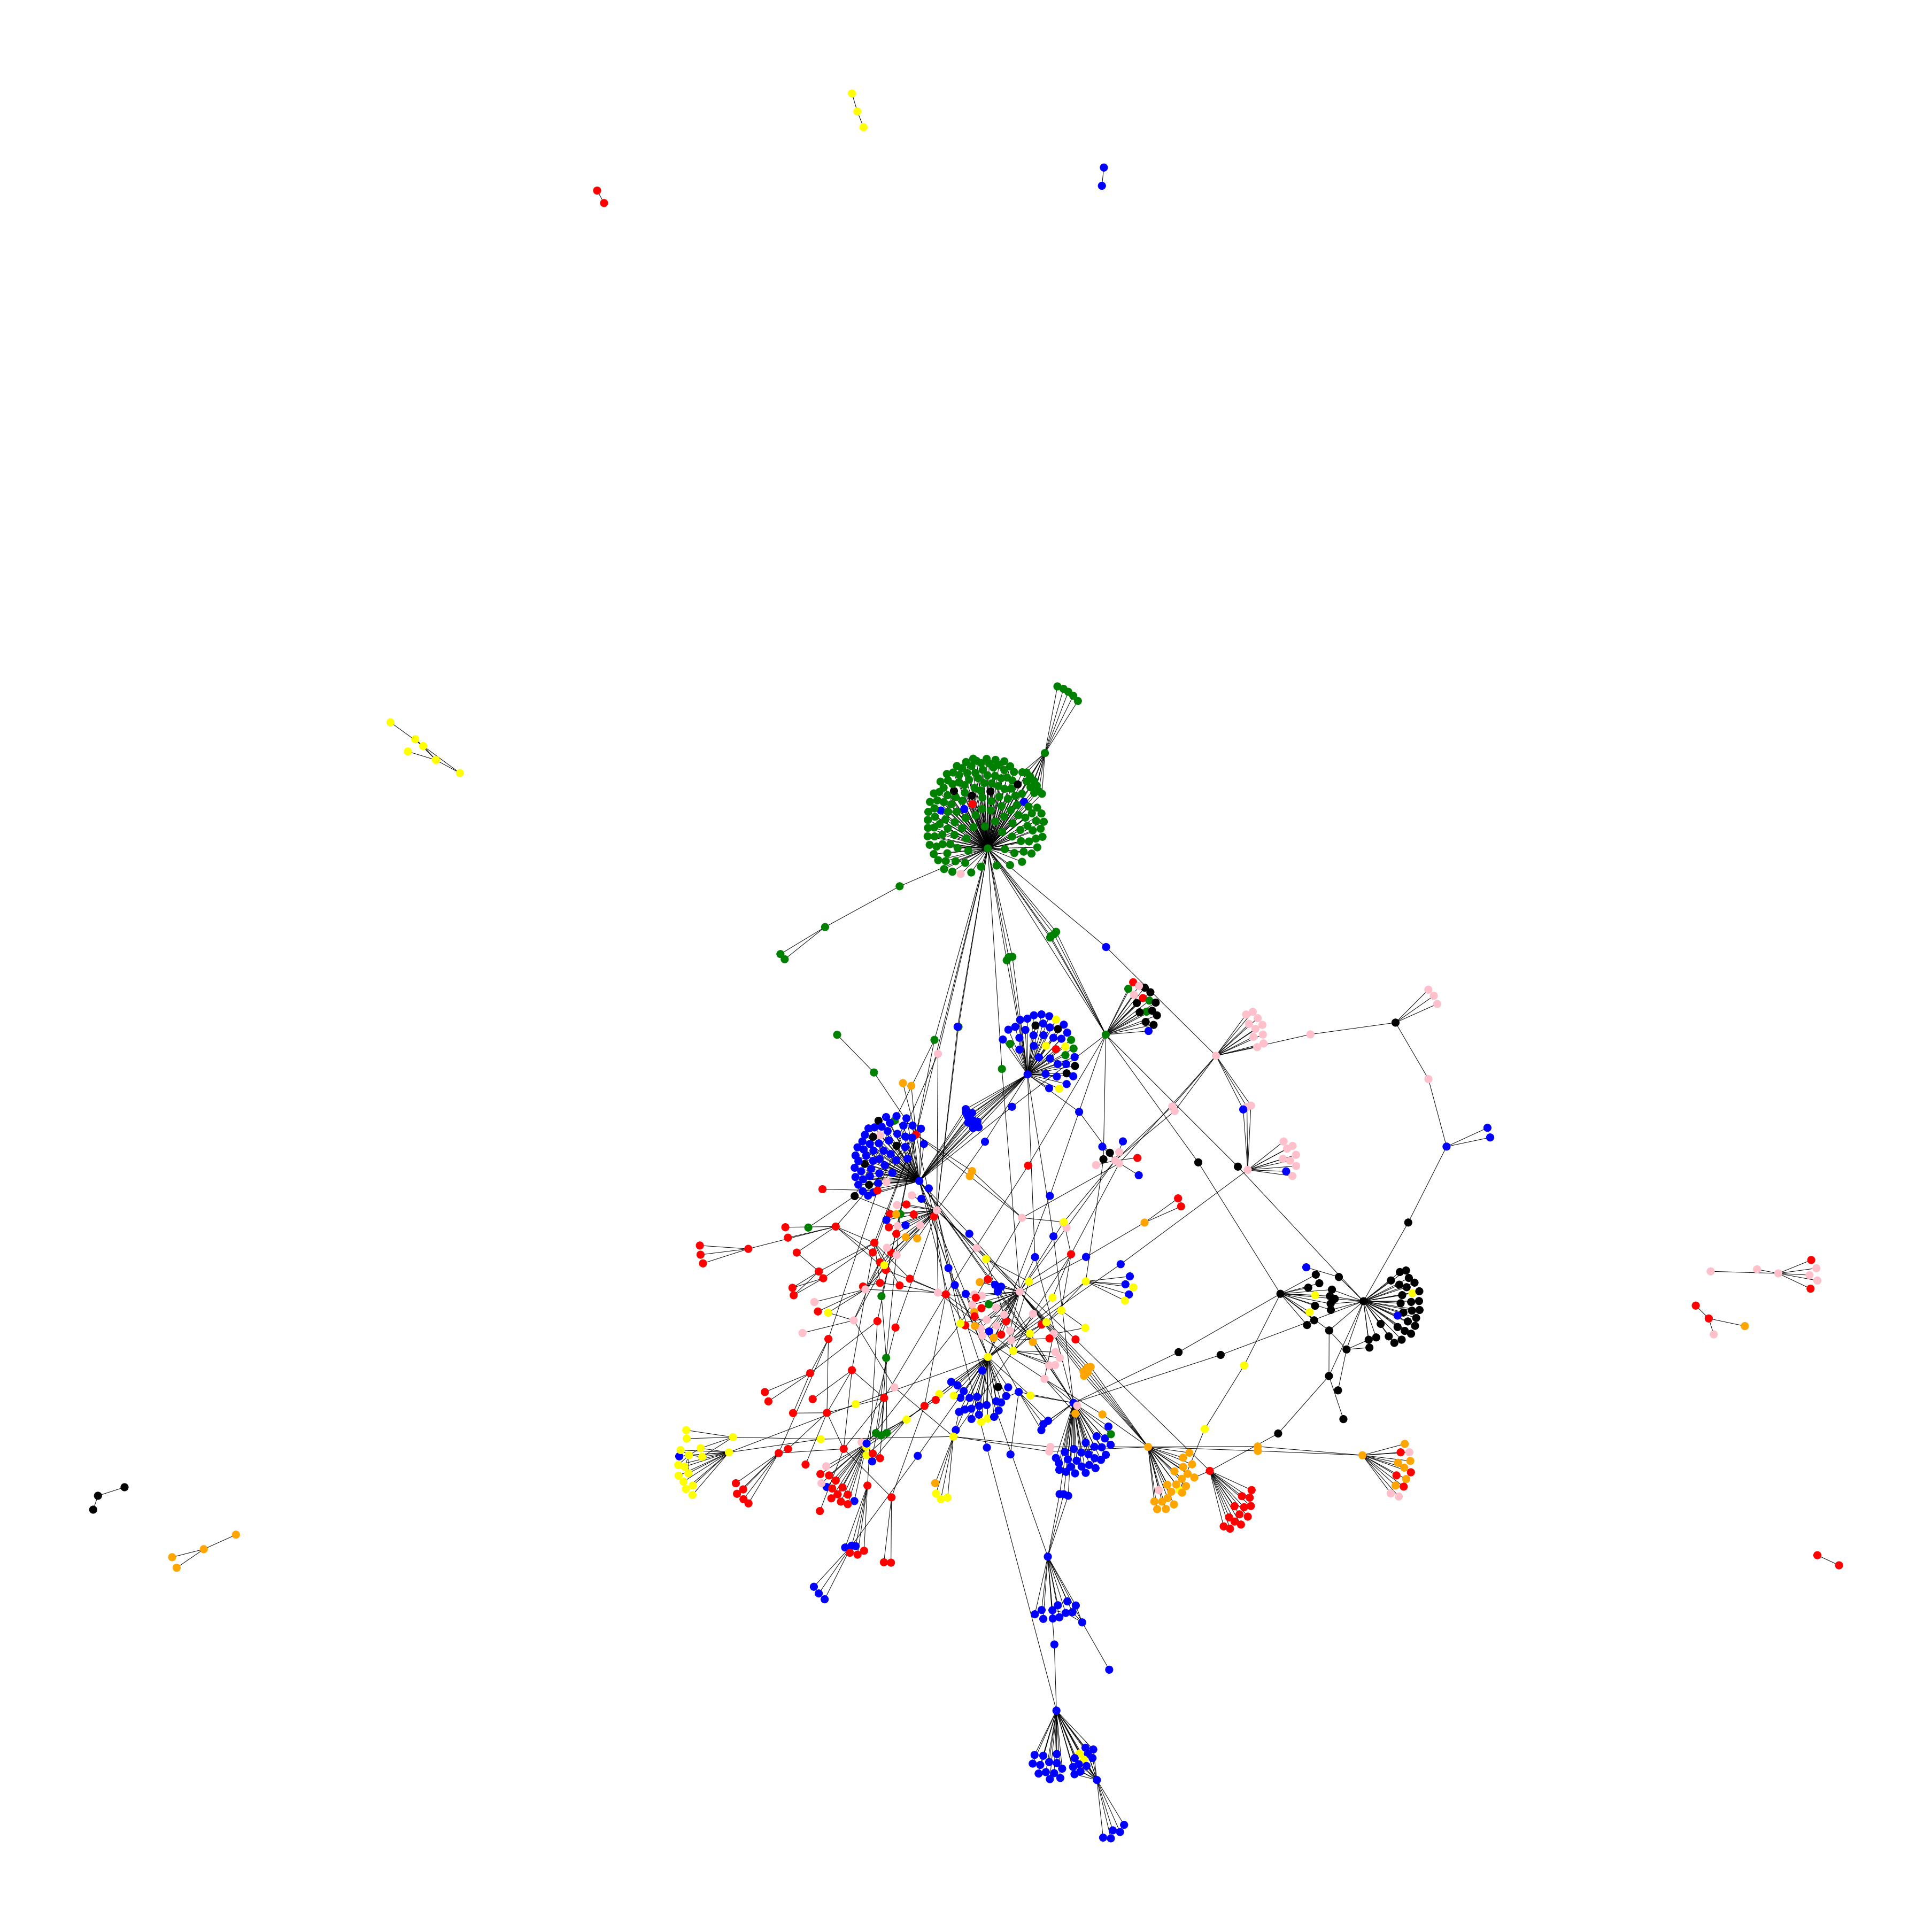

In [5]:
%matplotlib inline

import matplotlib.pyplot as plt
import networkx as nx

fig = plt.gcf()
fig.set_size_inches(50, 50)

G = nx.Graph()
G.add_edges_from(list(edges)[0:1000])

color_map = {0:'red', 1:'green', 2:'blue', 3:'yellow', 4:'black', 5:'orange', 6:'pink'}
colors = [color_map[i] for i in labels.numpy()[G.nodes()]]


nx.draw(G, node_size=200, node_color = colors)


plt.axis('off')
plt.show()

In [6]:
# Model and optimizer
model = GCN(nfeat=features.shape[1], nhid=hidden, nclass=labels.max().item() + 1, dropout=dropout)
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)



def test():
    model.eval()
    embedding, output = model(features, adj)
    loss_test = F.nll_loss(output[idx_test], labels[idx_test])
    acc_test = accuracy(output[idx_test], labels[idx_test])
    print("Test set results:",
          "loss= {:.4f}".format(loss_test.item()),
          "accuracy= {:.4f}".format(acc_test.item()))



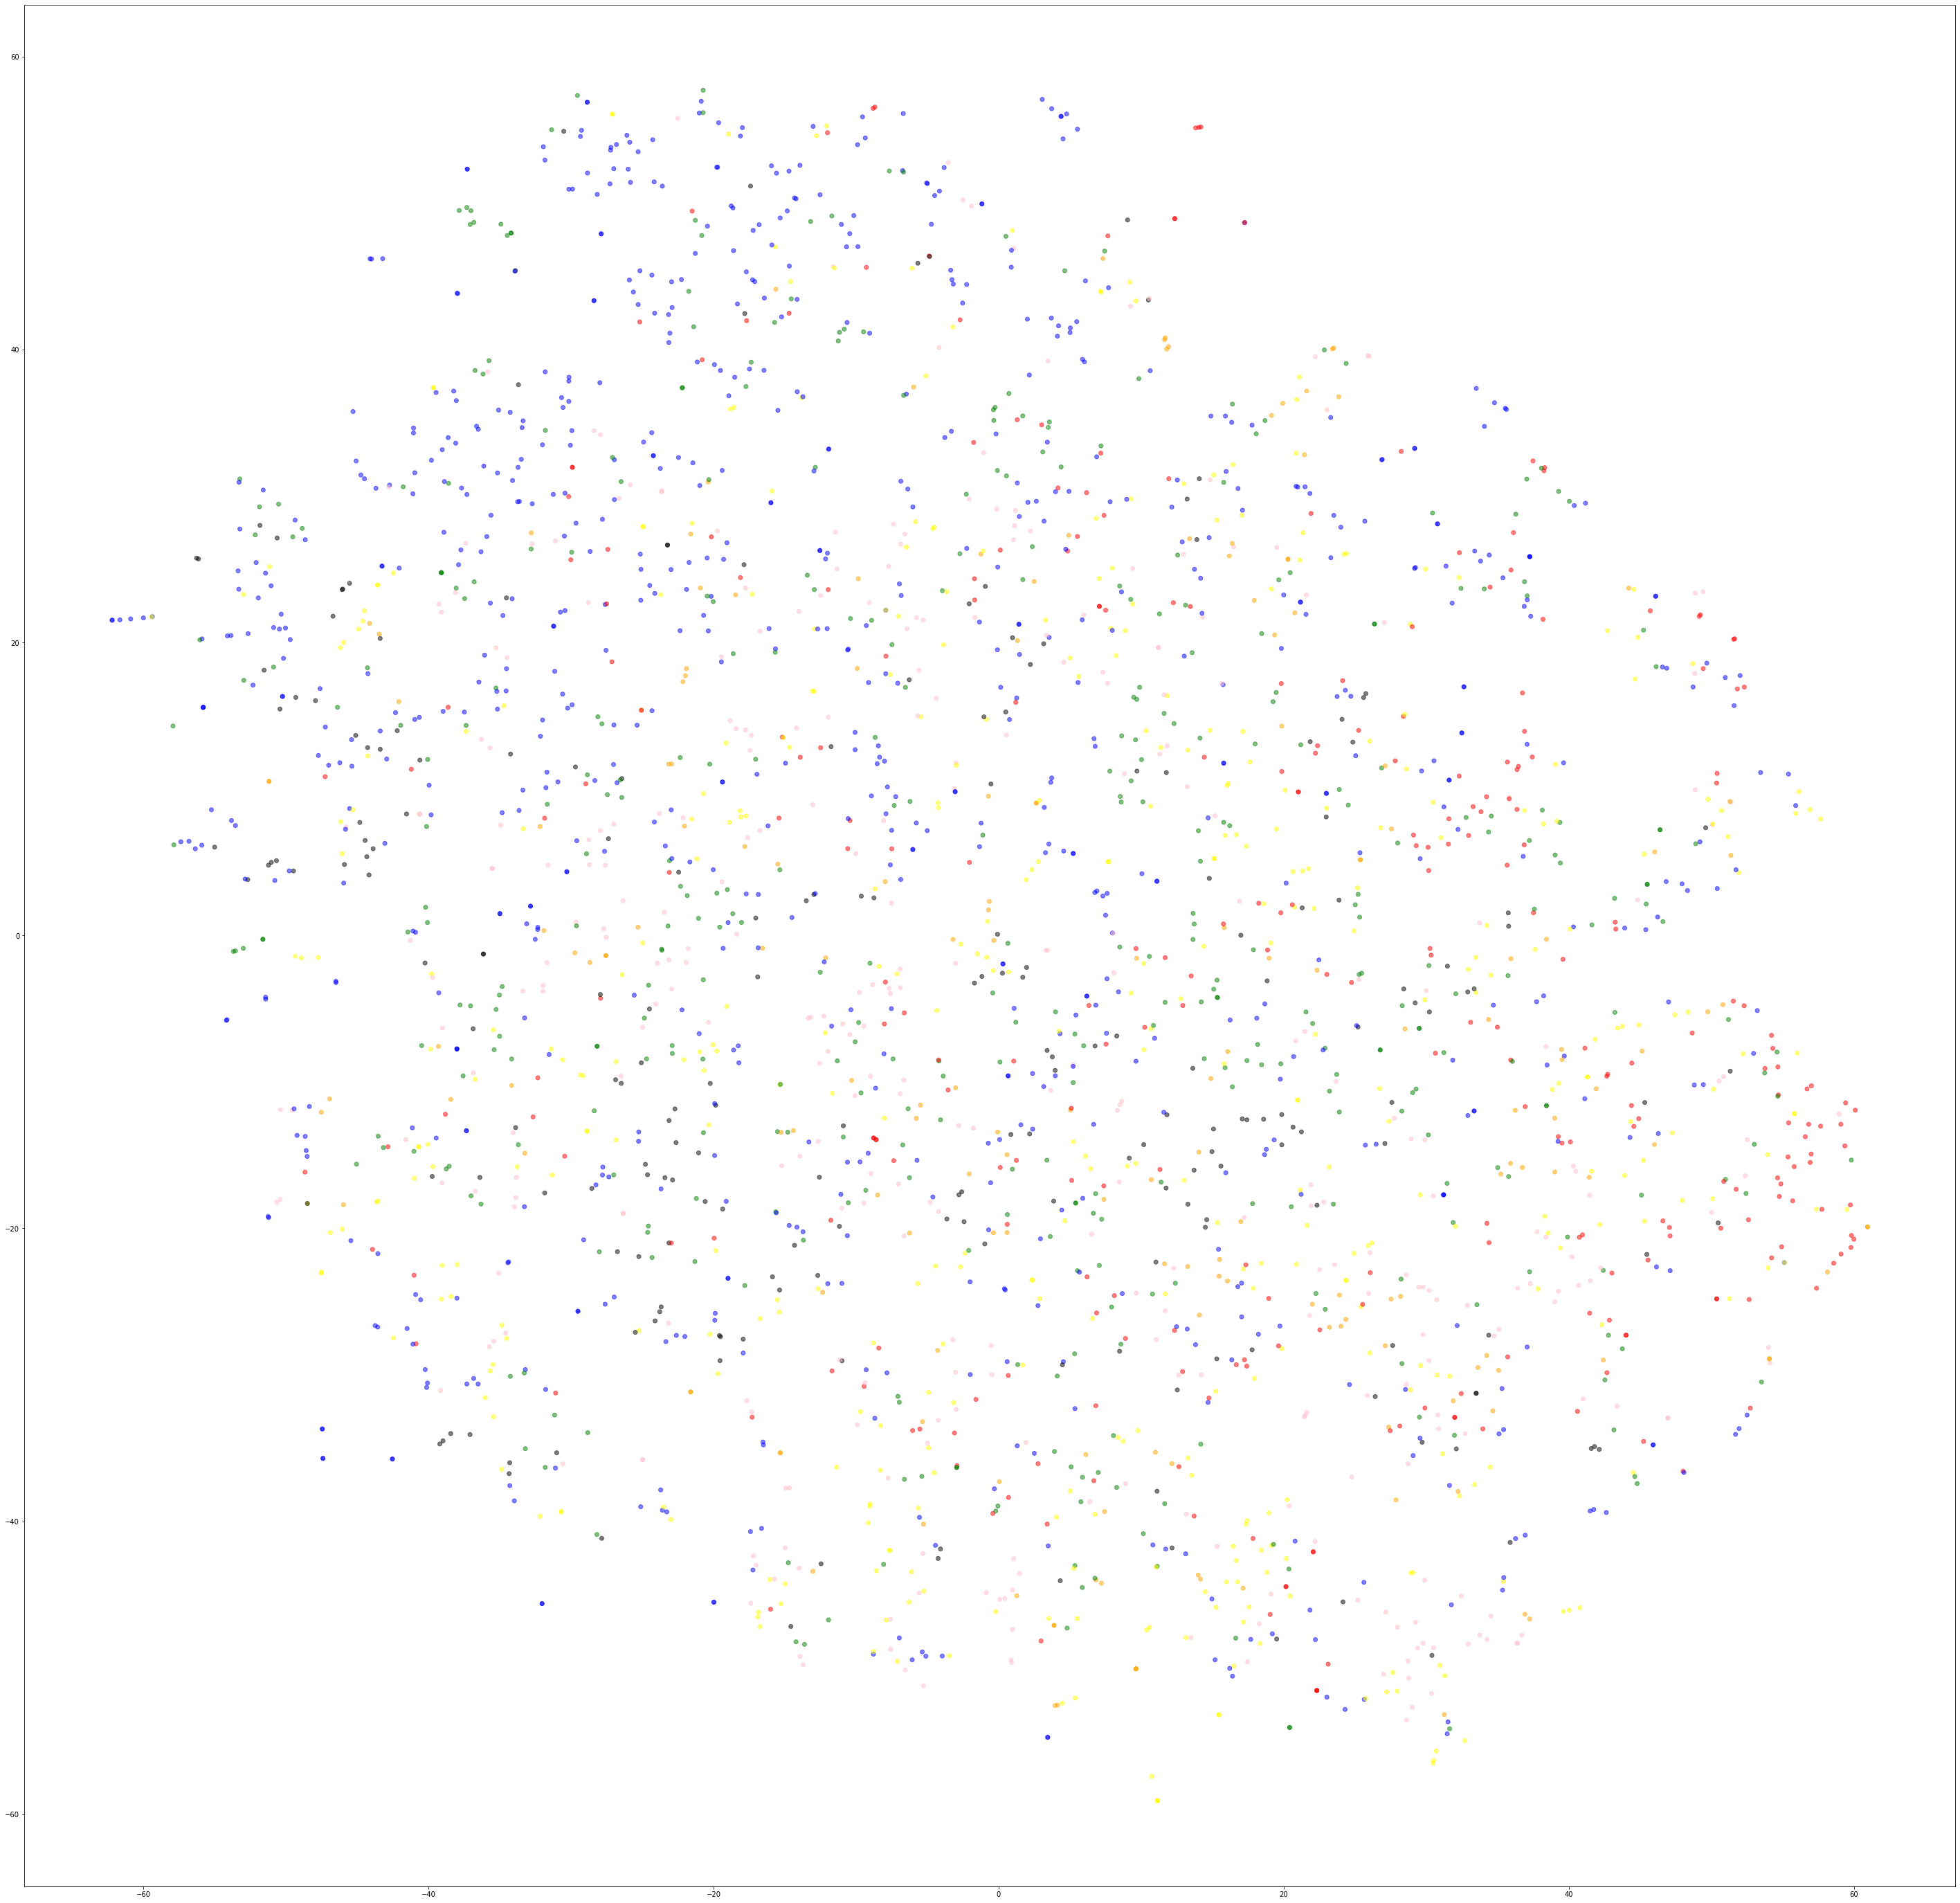

In [7]:
%matplotlib inline

embedding, output = model(features, adj)

import numpy as np
from sklearn.manifold import TSNE
X = np.array(embedding.detach().numpy())
X_embedded = TSNE(n_components=2).fit_transform(X)

fig = plt.gcf()
fig.set_size_inches(50, 50)


color_map = {0:'red', 1:'green', 2:'blue', 3:'yellow', 4:'black', 5:'orange', 6:'pink'}
colors = [color_map[i] for i in labels.numpy()]


plt.scatter(X_embedded.T[0], X_embedded.T[1], c = colors, alpha=0.5)
plt.show()

In [8]:
import math








t_total = time.time()
for epoch in range(epochs):
    t = time.time()
    model.train()
    optimizer.zero_grad()
    embedding, output = model(features, adj)
    loss_train = F.nll_loss(output[idx_train], labels[idx_train])
    acc_train = accuracy(output[idx_train], labels[idx_train])
    loss_train.backward()
    optimizer.step()


    model.eval()
    embedding, output = model(features, adj)

    loss_val = F.nll_loss(output[idx_val], labels[idx_val])
    acc_val = accuracy(output[idx_val], labels[idx_val])
    print('Epoch: {:04d}'.format(epoch+1),
          'loss_train: {:.4f}'.format(loss_train.item()),
          'acc_train: {:.4f}'.format(acc_train.item()),
          'loss_val: {:.4f}'.format(loss_val.item()),
          'acc_val: {:.4f}'.format(acc_val.item()),
          'time: {:.4f}s'.format(time.time() - t))

print("Optimization Finished!")
print("Total time elapsed: {:.4f}s".format(time.time() - t_total))

# Testing
test()


Epoch: 0001 loss_train: 1.9317 acc_train: 0.0741 loss_val: 1.9352 acc_val: 0.2996 time: 0.0275s
Epoch: 0002 loss_train: 1.9218 acc_train: 0.4444 loss_val: 1.9315 acc_val: 0.2996 time: 0.0359s
Epoch: 0003 loss_train: 1.9127 acc_train: 0.3704 loss_val: 1.9278 acc_val: 0.2996 time: 0.0319s
Epoch: 0004 loss_train: 1.9027 acc_train: 0.3704 loss_val: 1.9240 acc_val: 0.2996 time: 0.0279s
Epoch: 0005 loss_train: 1.8906 acc_train: 0.3704 loss_val: 1.9201 acc_val: 0.2996 time: 0.0349s
Epoch: 0006 loss_train: 1.8781 acc_train: 0.3704 loss_val: 1.9160 acc_val: 0.2996 time: 0.0259s
Epoch: 0007 loss_train: 1.8664 acc_train: 0.3704 loss_val: 1.9120 acc_val: 0.2996 time: 0.0279s
Epoch: 0008 loss_train: 1.8547 acc_train: 0.3704 loss_val: 1.9080 acc_val: 0.2996 time: 0.0349s
Epoch: 0009 loss_train: 1.8419 acc_train: 0.3704 loss_val: 1.9040 acc_val: 0.2996 time: 0.0399s
Epoch: 0010 loss_train: 1.8276 acc_train: 0.3704 loss_val: 1.9000 acc_val: 0.2996 time: 0.0299s
Epoch: 0011 loss_train: 1.8018 acc_train

Epoch: 0086 loss_train: 0.7675 acc_train: 0.8148 loss_val: 1.7197 acc_val: 0.3914 time: 0.0339s
Epoch: 0087 loss_train: 0.7534 acc_train: 0.7778 loss_val: 1.7105 acc_val: 0.3926 time: 0.0329s
Epoch: 0088 loss_train: 0.7637 acc_train: 0.8519 loss_val: 1.7011 acc_val: 0.3963 time: 0.0339s
Epoch: 0089 loss_train: 0.7414 acc_train: 0.8148 loss_val: 1.6902 acc_val: 0.3995 time: 0.0309s
Epoch: 0090 loss_train: 0.7123 acc_train: 0.7778 loss_val: 1.6787 acc_val: 0.4060 time: 0.0359s
Epoch: 0091 loss_train: 0.7051 acc_train: 0.8148 loss_val: 1.6686 acc_val: 0.4141 time: 0.0329s
Epoch: 0092 loss_train: 0.7420 acc_train: 0.7778 loss_val: 1.6612 acc_val: 0.4189 time: 0.0489s
Epoch: 0093 loss_train: 0.7910 acc_train: 0.8148 loss_val: 1.6549 acc_val: 0.4262 time: 0.0349s
Epoch: 0094 loss_train: 0.7432 acc_train: 0.8889 loss_val: 1.6493 acc_val: 0.4311 time: 0.0389s
Epoch: 0095 loss_train: 0.7047 acc_train: 0.8519 loss_val: 1.6435 acc_val: 0.4347 time: 0.0319s
Epoch: 0096 loss_train: 0.7726 acc_train

Epoch: 0171 loss_train: 0.3323 acc_train: 0.9630 loss_val: 1.4085 acc_val: 0.5289 time: 0.0349s
Epoch: 0172 loss_train: 0.3769 acc_train: 0.9259 loss_val: 1.4038 acc_val: 0.5317 time: 0.0339s
Epoch: 0173 loss_train: 0.3324 acc_train: 0.9630 loss_val: 1.3991 acc_val: 0.5330 time: 0.0369s
Epoch: 0174 loss_train: 0.3359 acc_train: 0.9630 loss_val: 1.3969 acc_val: 0.5317 time: 0.0299s
Epoch: 0175 loss_train: 0.3135 acc_train: 0.9630 loss_val: 1.3942 acc_val: 0.5317 time: 0.0319s
Epoch: 0176 loss_train: 0.3608 acc_train: 0.9630 loss_val: 1.3931 acc_val: 0.5269 time: 0.0309s
Epoch: 0177 loss_train: 0.3167 acc_train: 0.9630 loss_val: 1.3927 acc_val: 0.5233 time: 0.0319s
Epoch: 0178 loss_train: 0.3436 acc_train: 0.9630 loss_val: 1.3919 acc_val: 0.5237 time: 0.0289s
Epoch: 0179 loss_train: 0.2845 acc_train: 1.0000 loss_val: 1.3899 acc_val: 0.5237 time: 0.0309s
Epoch: 0180 loss_train: 0.3330 acc_train: 0.9630 loss_val: 1.3859 acc_val: 0.5285 time: 0.0319s
Epoch: 0181 loss_train: 0.3845 acc_train

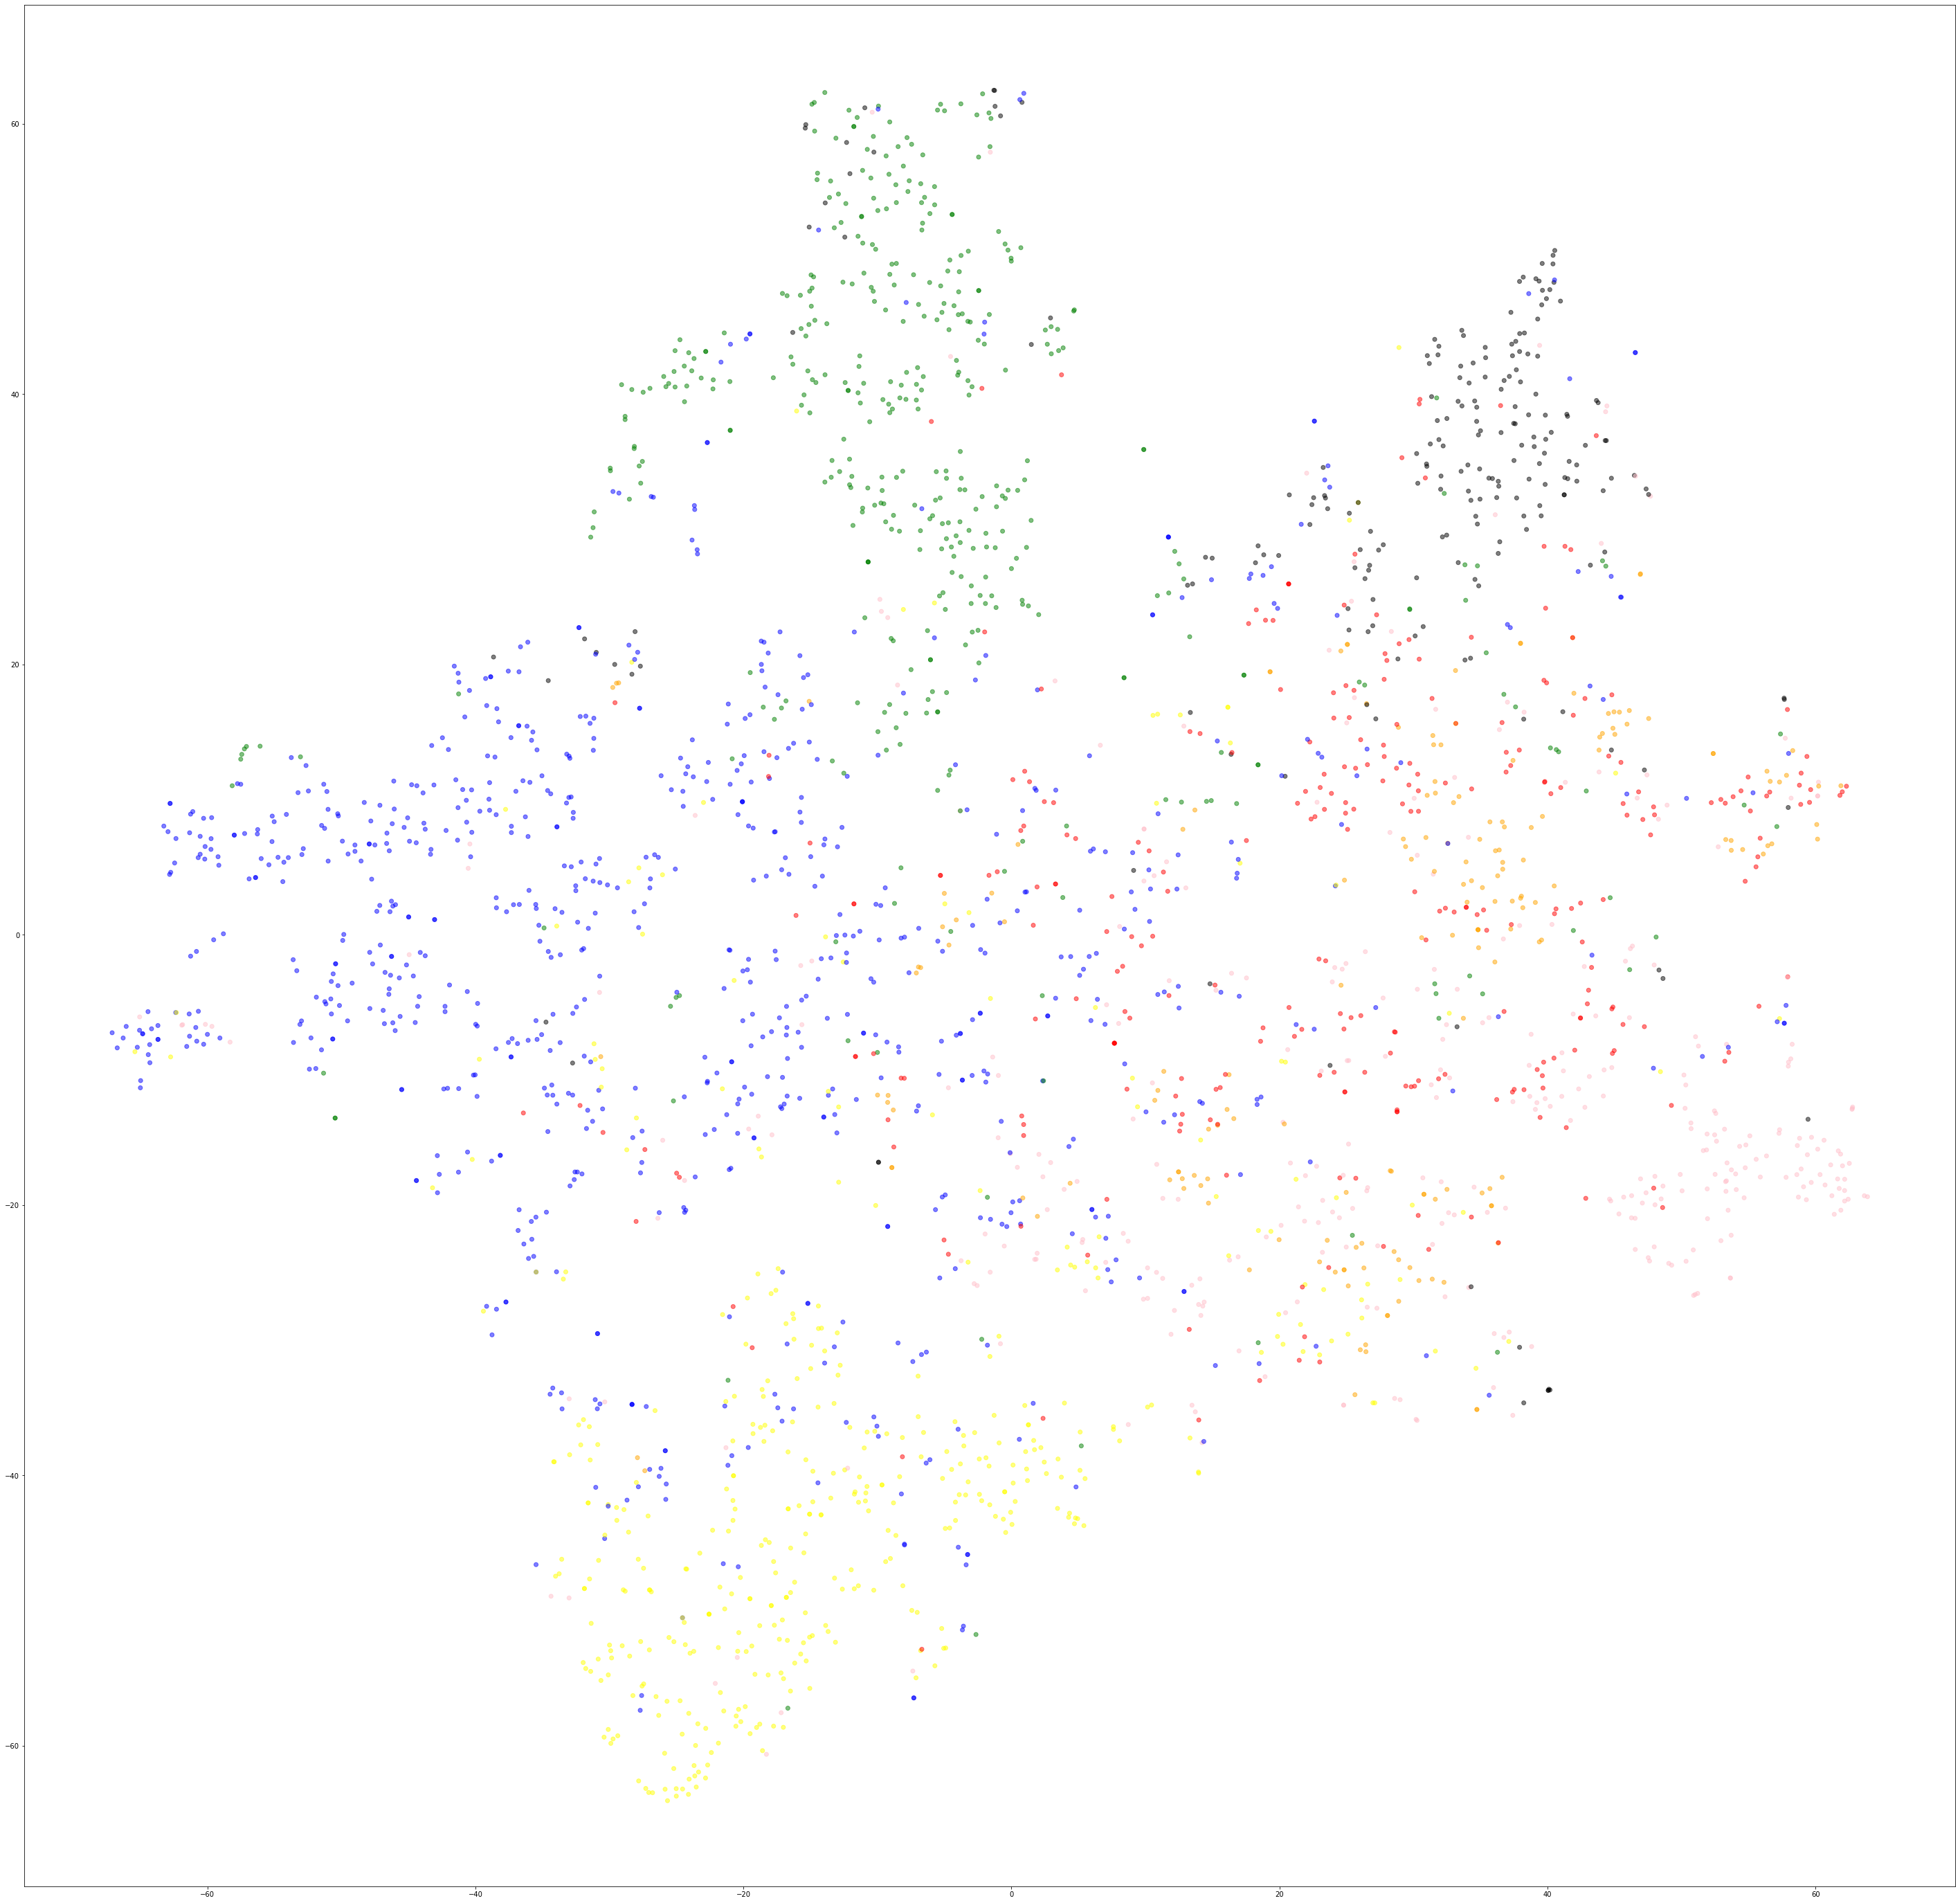

In [9]:
%matplotlib inline

embedding, output = model(features, adj)

import numpy as np
from sklearn.manifold import TSNE
X = np.array(embedding.detach().numpy())
X_embedded = TSNE(n_components=2).fit_transform(X)

fig = plt.gcf()
fig.set_size_inches(50, 50)


color_map = {0:'red', 1:'green', 2:'blue', 3:'yellow', 4:'black', 5:'orange', 6:'pink'}
colors = [color_map[i] for i in labels.numpy()]


plt.scatter(X_embedded.T[0], X_embedded.T[1], c = colors, alpha=0.5)
plt.show()